In [1]:

import sys

# Add the notebooks folder (where audio_generator.py lives) to Python's module search path
sys.path.append("/content/drive/MyDrive/speech-recognition-benchmark/notebooks")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/speech-recognition-benchmark

/content/drive/MyDrive/speech-recognition-benchmark


In [ ]:
!pip install -r requirements.txt
!apt-get update -qq && apt-get install -y -qq ffmpeg


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import whisper
from jiwer import wer
import nemo.collections.asr as nemo_asr
from audio_generator import text_to_audio
import soundfile as sf


In [17]:
audio_path = "audio/test1.wav"
ground_truth = '''Once upon a time, in a quiet village nestled between green hills and winding streams,
there lived a curious weaver named Marner. He would wake before dawn to tend to his loom,
listening to the soft rhythms of the shuttle and the distant songs of the morning birds.
Each day he would think about the stories he had heard as a child — tales of travelers,
storms weathered, and friendships that bound the villagers together. On this particular day,
Marner decided to walk to the market to see what news had arrived from the neighboring town.
He had no idea that a short conversation would change the way he viewed his work and his life.'''

In [18]:


audio, sr = text_to_audio(ground_truth)

# Save manually
out_path = audio_path
sf.write(out_path, audio, sr)
print("Saved:", out_path)

Saved: audio/test1.wav


In [5]:

def benchmark_whisper(audio_path: str, ground_truth: str, model_size="small"):
    """
    Benchmark Whisper ASR model on one audio file.

    Args:
        audio_path (str): path to .wav file
        ground_truth (str): reference transcript
        model_size (str): whisper model size (tiny, base, small, medium, large)
                          default = "small"

    Returns:
        dict with {model, latency, transcript, WER}
    """
    # Load model (downloads if not cached)
    model = whisper.load_model(model_size)

    # Run inference with timing
    start = time.time()
    result = model.transcribe(audio_path)
    end = time.time()

    latency = end - start
    transcript = result["text"].strip()
    error = wer(ground_truth.lower(), transcript.lower())

    return {
        "model": f"whisper-{model_size}",
        "latency_sec": round(latency, 2),
        "transcript": transcript,
        "WER": round(error, 3)
    }


In [11]:

res = benchmark_whisper(audio_path, ground_truth)
print(pd.DataFrame([res]))
print(res['transcript'])


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


,model,latency_sec,transcript,WER
0,whisper-small,41.54,"Once upon a time, in a quiet village nestled b...",0.017


In [26]:
def benchmark_nemo(model_name: str, audio_path: str, ground_truth: str):
    """
    Benchmark a NeMo ASR model (Parakeet or Conformer).
    """
    # Load model
    model = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name=model_name)

    # Time inference
    start = time.time()
    transcript_result = model.transcribe([audio_path])[0]
    end = time.time()

    # Extract transcript string - handle potential Hypothesis object or string
    if isinstance(transcript_result, str):
        transcript = transcript_result
    elif hasattr(transcript_result, 'text'):
        transcript = transcript_result.text
    else:
        transcript = str(transcript_result) # Fallback to string conversion


    latency = end - start
    error = wer(ground_truth.lower(), transcript.lower())

    return {
        "model": model_name,
        "latency_sec": latency,
        "transcript": transcript,
        "WER": error
    }

In [34]:
results = []



# Whisper small
results.append(benchmark_whisper(audio_path, ground_truth, model_size="small"))

# NeMo Parakeet small
results.append(benchmark_nemo("nvidia/parakeet-tdt_ctc-110m", audio_path, ground_truth))

# NeMo Conformer small
results.append(benchmark_nemo("stt_en_conformer_ctc_small", audio_path, ground_truth))






[NeMo I 2025-09-14 05:07:32 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-09-14 05:07:33 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: null
    shuffle: true
    num_workers: 8
    pin_memory: true
    max_duration: 40
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: fully_randomized
    bucketing_batch_size: null
    shard_manifests: true
    use_lhotse: true
    use_bucketing: true
    num_buckets: 30
    bucket_duration_bins: null
    batch_duration: 600
    defer_setup: true
    
[NeMo W 2025-09-14 05:07:33 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation co

[NeMo I 2025-09-14 05:07:33 nemo_logging:393] PADDING: 0
[NeMo I 2025-09-14 05:07:34 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-09-14 05:07:34 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}


[NeMo W 2025-09-14 05:07:34 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available


[NeMo I 2025-09-14 05:07:35 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}


[NeMo W 2025-09-14 05:07:35 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available


[NeMo I 2025-09-14 05:07:35 nemo_logging:393] Model EncDecHybridRNNTCTCBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--parakeet-tdt_ctc-110m/snapshots/431a349f3051ab85c22b9b7a2741b5fe77065665/parakeet-tdt_ctc-110m.nemo.


Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]

[NeMo I 2025-09-14 05:07:41 nemo_logging:393] Found existing object /root/.cache/torch/NeMo/NeMo_2.4.0/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo.
[NeMo I 2025-09-14 05:07:41 nemo_logging:393] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.4.0/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo
[NeMo I 2025-09-14 05:07:41 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo I 2025-09-14 05:07:42 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-09-14 05:07:43 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2025-09-14 05:07:43 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librisp

[NeMo I 2025-09-14 05:07:43 nemo_logging:393] PADDING: 0
[NeMo I 2025-09-14 05:07:44 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo.


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


In [41]:
df = pd.DataFrame(results )
df = df.drop(columns=['transcript'])
df = df.set_index('model')

In [42]:
df

,latency_sec,WER
model,,
whisper-small,39.180000,0.017000
nvidia/parakeet-tdt_ctc-110m,6.061743,0.026087
stt_en_conformer_ctc_small,2.330583,0.130435


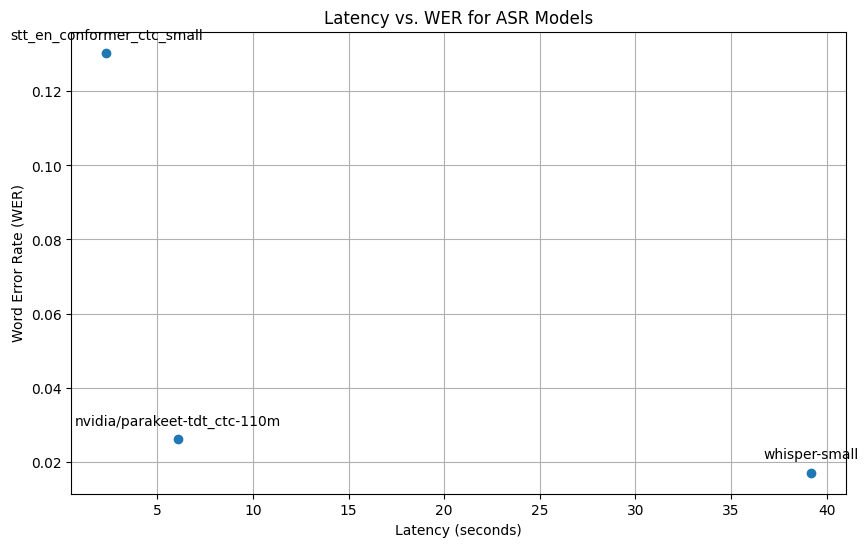

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(df['latency_sec'], df['WER'])

# Add model names as labels
for i, model_name in enumerate(df.index):
    ax.annotate(model_name, (df['latency_sec'][i], df['WER'][i]), textcoords="offset points", xytext=(0,10), ha='center')

ax.set_xlabel('Latency (seconds)')
ax.set_ylabel('Word Error Rate (WER)')
ax.set_title('Latency vs. WER for ASR Models')
ax.grid(True)

plt.show()